# IMPORTS

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json

In [3]:
data=pd.read_csv('Bengaluru_House_Data.csv')

In [4]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df=data.copy()

# Data Cleaning

In [6]:
# We know area_type , availability and society won't impact the prices much,so we will drop them
df=df.drop(['area_type','availability','society','balcony'],axis=1)

In [7]:
df.shape

(13320, 5)

In [8]:
#Lets look at the null values
df.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df=df.dropna()
df2=df.reset_index(drop=True)

In [10]:
df2.shape

(13246, 5)

In [11]:
#size has to be integer, so we will remove BHK from it and extract the integer value
df2['bhk']=df2['size'].apply(lambda x: int(x.split(' ')[0]))

In [12]:
df2.drop(['size'],axis=1)
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [13]:
#total_sqft is object type,lets see why
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [14]:
#Looking at the values that can't be converted into float
df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
120,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
135,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
163,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
186,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
406,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
545,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
642,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
655,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
665,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [15]:
#For value in range, we will take mean and drop the values in other units
def to_float(x):
  splitted=x.split('-')
  if len(splitted)==2:
    return (float(splitted[0])+float(splitted[1]))/2
  try:
    return float(x)
  except:
    return None

In [16]:
df2['total_sqft']=df2['total_sqft'].apply(to_float)
df2=df2[df2.total_sqft.notnull()]
df3=df2.reset_index(drop=True)
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [17]:
#Feature Engineering
df3['price_per_sqft']=df3['price']*100000/df3['total_sqft']
df3.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [18]:
#Lets handle locations 
df3['location'].value_counts()

Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: location, Length: 1298, dtype: int64

In [19]:
#There are 1298 different values so we will try to reduce dimentionality
d1=df3['location'].value_counts()
d2=d1[d1<=10]

In [20]:
df3.location=df3.location.apply(lambda x: 'others' if x in d2 else x)


In [21]:
df3.shape

(13200, 7)

In [22]:
#Normally we have >=300sqft per bhk, values lesser than this shall be considered inaccurate data
df3[df3.total_sqft/df3.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,others,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
57,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
67,others,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
69,others,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [23]:
df3 = df3[~(df3.total_sqft/df3.bhk<300)]
df3.shape

(12456, 7)

<AxesSubplot: xlabel='price_per_sqft'>

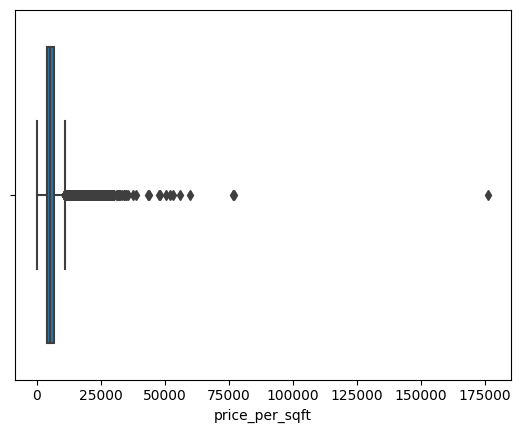

In [24]:
#For outkiers in price_per_sqft
sns.boxplot(x=df3['price_per_sqft'])

In [25]:
#Remove outliers in data
def price_per_sqft_out(df):
  df_out=pd.DataFrame()
  for key,value in df.groupby('location'):
    mean=np.mean(value.price_per_sqft)
    std=np.std(value.price_per_sqft)
    reduced_df=value[(value.price_per_sqft>(mean-std))&(value.price_per_sqft<=(mean+std))]
    df_out=pd.concat([df_out,reduced_df],ignore_index=True)
  return df_out

In [26]:
df4=price_per_sqft_out(df3)
df4.shape

(10245, 7)

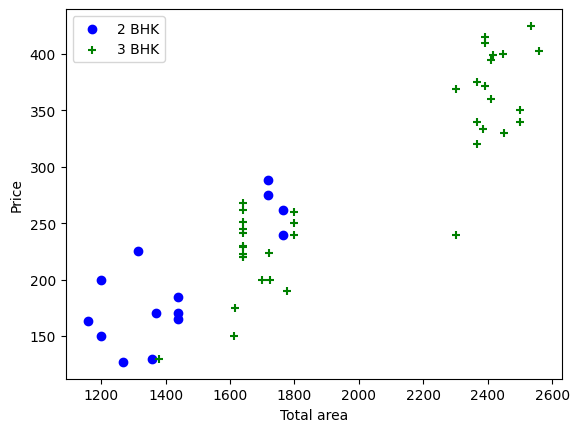

In [27]:
# Ootliers of BHK
bhk2 = df4[(df4.location=='Rajaji Nagar') & (df4.bhk==2)]
bhk3 = df4[(df4.location=='Rajaji Nagar') & (df4.bhk==3)]
plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK')
plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK')
plt.xlabel('Total area')
plt.ylabel('Price')
plt.legend()

In [28]:
#Removing the outliers when lesser bhk has more price
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
             exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [29]:
df5=remove_bhk_outliers(df4)
df5.shape

(7331, 7)

In [30]:
# Removing outliers with high no. of baths
df6=df5[df5.bath<df5.bhk+2]
df6.shape

(7253, 7)

In [31]:
df7=df6.drop(['size','price_per_sqft'],axis=1)
df7.shape

(7253, 5)

In [32]:
df_dum=pd.get_dummies(df7['location'],drop_first=True)
df8=pd.concat([df7,df_dum],axis=1)
df8=df8.drop(['location'],axis=1)

In [33]:
df8.shape

(7253, 244)

# Creating train and test data

In [34]:
x=df8.drop(['price'],axis=1)
y=df8['price']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [36]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [37]:
#Linear Regression model
lr=LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.8595687461072152

In [38]:
#Random Forest Regressor model
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_test,y_test)

0.8809099359960793

In [39]:
with open('rf_model_final.pickle','wb') as f:
  pickle.dump(rf,f)

In [40]:
columns={
    'data_columns': [col.lower() for col in x.columns]
}

In [41]:
with open('columns.json','w') as f:
  f.write(json.dumps(columns))